In [73]:
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
from sklearn.decomposition import PCA
from math import exp
from math import log
import matplotlib.pyplot as plt

In [2]:
def parseData(fname):
  for l in urlopen(fname):
    yield eval(l)

In [3]:
print("Reading data...")
data = list(parseData("http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json"))
print("done")

Reading data...
done


In [29]:
def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

In [30]:
X = [feature(d) for d in data]
y = [d['beer/ABV'] >= 6.5 for d in data]

In [31]:
def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

In [32]:
def sigmoid(x):
  return 1.0 / (1 + exp(-x))

In [33]:
##################################################
# Logistic regression by gradient ascent         #
##################################################


In [34]:
# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

In [35]:
# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

X_train = X
y_train = y


In [36]:
##################################################
# Train                                          #
##################################################

def train(lam, X, y):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X, y, lam))
  return theta

In [37]:
def performance(theta, X, y):
  scores = [inner(theta,x) for x in X]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,y)]
  acc = sum(correct) * 1.0 / len(correct)
  return acc

In [38]:
def predictions(theta, X):
    scores = [inner(theta,x) for x in X]
    predictions = [s > 0 for s in scores]
    return predictions

In [39]:
def report_accuracies(lam, acc, title = ""):
    print(title + " --->\t" "lambda = " + str(lam) + ":\taccuracy = " + str(acc))

In [40]:
##################################################
# Validation pipeline                            #
##################################################

lam = 1.0

theta = train(lam, X, y)
acc = performance(theta, X, y)
report_accuracies(lam, acc)

 --->	lambda = 1.0:	accuracy = 0.71868


### 1. Split the data and test

Training Set --->	accuracy = 0.669946601068

Validation Set --->	accuracy = 0.900756030241

Testing Set --->	accuracy = 0.577188456231


In [45]:
# Split the sets - X was already made a feature above
training_set_X = X[:16667]
training_set_y = y[:16667]
validation_set_X = X[16667:33333]
validation_set_y = y[16667:33333]
test_set_X = X[33333:]
test_set_y = y[33333:]

In [46]:
# Get the accuracies for each set
#X_train = training_set_X
#y_train = training_set_y

theta = train(lam, training_set_X, training_set_y)
acc = performance(theta, training_set_X, training_set_y)
report_accuracies(lam, acc, "Training Set")

acc = performance(theta, validation_set_X, validation_set_y)
report_accuracies(lam, acc, "Validation Set")

acc = performance(theta, test_set_X, test_set_y)
report_accuracies(lam, acc, "Testing Set")

Training Set --->	lambda = 1.0:	accuracy = 0.669946601068
Validation Set --->	lambda = 1.0:	accuracy = 0.900756030241
Testing Set --->	lambda = 1.0:	accuracy = 0.577188456231


### 2. More accurate classifier

In [47]:
# Find the number of times a list of words occurs in a review. Return a list with the counts

def wordCount (word_list, datum):
    description = datum["review/text"].lower()
    description = description.replace(".", " ")
    description = description.replace(",", " ")
    words = description.split()
    counts = []
    for word in word_list:
        counts.append(words.count(word))
    #print(counts)
    return counts


In [48]:
# Createa feature based on the number of counts of each of the following 10 words within the description
# 'lactic', 'tart', 'sour', 'citric',  'sweet', 'acid', 'hop', 'fruit', 'salt', 'spicy'
def feature (datum, with_one = True):
    if with_one == True:
        feat = [1] + ((wordCount(['lactic', 'tart', 'sour', 'citric',  'sweet', 'acid', 'hop', 'fruit', 'salt', 'spicy'], datum)))
    else:
        feat = ((wordCount(['lactic', 'tart', 'sour', 'citric',  'sweet', 'acid', 'hop', 'fruit', 'salt', 'spicy'], datum)))
    return feat

In [49]:
# Get the X any y
X = [feature(d) for d in data]
y = [d['beer/ABV'] >= 6.5 for d in data]

# Split the data into the training, validation, and testing set
# Split the sets
training_set_X = X[:16667]
training_set_y = y[:16667]
validation_set_X = X[16667:33333]
validation_set_y = y[16667:33333]
test_set_X = X[33333:]
test_set_y = y[33333:]

In [50]:
# Get the accuracies for each set
#X_train = training_set_X
#y_train = training_set_y

theta = train(lam, training_set_X, training_set_y)
acc = performance(theta, training_set_X, training_set_y)
report_accuracies(lam, acc, "Training Set")

acc = performance(theta, validation_set_X, validation_set_y)
report_accuracies(lam, acc, "Validation Set")

acc = performance(theta, test_set_X, test_set_y)
report_accuracies(lam, acc, "Testing Set")

Training Set --->	lambda = 1.0:	accuracy = 0.562548749025
Validation Set --->	lambda = 1.0:	accuracy = 0.946357854314
Testing Set --->	lambda = 1.0:	accuracy = 0.362152756945


### 3. True/False Positives and Negatives, and Balanced Error Rate

In [51]:
# Balanced Error Rate Method
def ber (tp, tn, fp, fn): 
    ber_ret = 0.5 * (fp/(fp + tn) + fn/(fn+tp))
    return ber_ret


In [52]:
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

prediction_y  = list(predictions(theta, test_set_X))
test_set_y = list(test_set_y)
for i in range(len(prediction_y)):
    if (prediction_y[i] == test_set_y[i]) and (prediction_y[i] == True):
        true_positives+=1
    elif prediction_y[i] == test_set_y[i] and prediction_y[i] == False:
        true_negatives+=1
    elif prediction_y[i] != test_set_y[i] and prediction_y[i] == True:
        false_positives+=1
    else:
        false_negatives+=1
        
print("True Positives: ", true_positives)
print("True Negatives: ", true_negatives)
print("False Positives: ", false_positives)
print("False negatives: ", false_negatives)
print("BER: ", ber(true_positives, true_negatives, false_positives, false_negatives))



True Positives:  5832
True Negatives:  204
False Positives:  10551
False negatives:  80
BER:  0.4972819389162859


### 4. Comparing performance of classifiers with differnt lambdas

Accuracies on the validation set for each lambda:

Validation Set --->	lambda = 0:	accuracy = 0.946357854314

Validation Set --->	lambda = 0.01:	accuracy = 0.946357854314

Validation Set --->	lambda = 0.1:	accuracy = 0.946357854314

Validation Set --->	lambda = 1:	accuracy = 0.946357854314

Validation Set --->	lambda = 100:	accuracy = 0.952778111124


#### The best lambda was 100. The acuuracies for each of the sets with lambda = 100 is:

Training Set --->	lambda = 100:	accuracy = 0.561348773025

Validation Set --->	lambda = 100:	accuracy = 0.952778111124

Testing Set --->	lambda = 100:	accuracy = 0.356152876942


In [53]:
# Get the accuracy using different lambdas on the validation set
lambdas = [0, .01, .1, 1, 100]
for lam in lambdas:
    theta = train(lam, training_set_X, training_set_y)
    acc = performance(theta, validation_set_X, validation_set_y)
    report_accuracies(lam, acc, "Validation Set")


Validation Set --->	lambda = 0:	accuracy = 0.946357854314
Validation Set --->	lambda = 0.01:	accuracy = 0.946357854314
Validation Set --->	lambda = 0.1:	accuracy = 0.946357854314
Validation Set --->	lambda = 1:	accuracy = 0.946357854314
Validation Set --->	lambda = 100:	accuracy = 0.952778111124


In [54]:
# Get the results for all three sets with lambda = 100
lam = 100

theta = train(lam, training_set_X, training_set_y)
acc = performance(theta, training_set_X, training_set_y)
report_accuracies(lam, acc, "Training Set")

acc = performance(theta, validation_set_X, validation_set_y)
report_accuracies(lam, acc, "Validation Set")

acc = performance(theta, test_set_X, test_set_y)
report_accuracies(lam, acc, "Testing Set")

Training Set --->	lambda = 100:	accuracy = 0.561348773025
Validation Set --->	lambda = 100:	accuracy = 0.952778111124
Testing Set --->	lambda = 100:	accuracy = 0.356152876942


### 5. PCA Components

See output for components

In [56]:
pca = PCA()
training_set_X = data[:len(training_set_X)]
X = [feature(d, with_one = False) for d in training_set_X]
pca.fit(X)

explained_var_10 = pca.explained_variance_
pca.components_


array([[ -7.24610180e-04,   3.85694421e-03,  -1.00688641e-02,
          9.77779166e-03,   8.07183505e-01,  -4.17417567e-04,
          5.84902652e-01,   7.18723815e-02,   9.31142184e-05,
          3.10719552e-02],
       [ -1.41372375e-03,  -8.80615572e-03,  -1.47242196e-02,
          1.40808580e-02,  -5.86980464e-01,   3.25576660e-04,
          8.09210065e-01,  -1.68332678e-03,  -1.07927898e-03,
          1.15879951e-02],
       [  3.95438582e-03,   4.21123272e-02,   8.42900443e-02,
          2.76361244e-03,  -5.99043840e-02,  -1.35775240e-04,
         -3.99166256e-02,   9.92369840e-01,   1.72199345e-04,
          3.34461687e-02],
       [ -3.76731835e-04,   2.08450865e-02,  -1.32468475e-02,
          2.03859869e-02,  -1.64534816e-02,  -7.46749388e-05,
         -2.66712914e-02,  -3.55292635e-02,   2.81079766e-03,
          9.98359636e-01],
       [  2.55416071e-02,   2.30813793e-01,   9.68048908e-01,
          3.30276808e-03,   2.94931825e-03,   9.77008934e-03,
          2.19835825e-02

### 6. Representing first data point using PCA
 
See solution below

In [57]:
print(pca.fit_transform(X)[0])

[-0.64689613 -0.00650866 -0.04509619 -0.03860312  0.22861243  1.02583256
 -0.01062785  1.95501061 -0.09472702 -0.00362346]


### 7. Reconstrruction error of representing data in two dimensions

Reconstruction Error:  3.77361978073

In [65]:
pca = PCA(n_components=2)

pca.fit(X)

rec_error = sum(explained_var_10[2:])
print("Reconstruction Error: ", rec_error * 8)


Reconstruction Error:  3.77361978073


### 8. Plotting the Data

In [90]:
print(two_dim_rep[:10])

[[-0.6468961277656085, -0.00650866374536756], [-0.5774314701552973, 0.003441612688474553], [-0.06440119993955362, 0.8143350040314887], [3.526954619305436, 0.6718137410536176], [0.15787965367613085, -0.5818555245611511], [-0.6493038516191408, 0.005124939471479182], [-0.6182318964310115, 0.016712934552591405], [-0.6493038516191408, 0.005124939471479182], [-0.6493038516191408, 0.005124939471479182], [-0.03332924475142414, 0.8259229991126011]]


In [107]:
two_dim_rep = (pca.fit_transform(X)).tolist()
print()
x_coord = [d[0] for d in two_dim_rep]
y_coord = [d[1] for d in two_dim_rep]
color_coord = [d['beer/style'] == 'American IPA' for d in data]

color = []
for d in color_coord:
    if d == True:
        color.append('red') 
    else:
        color.append('blue')

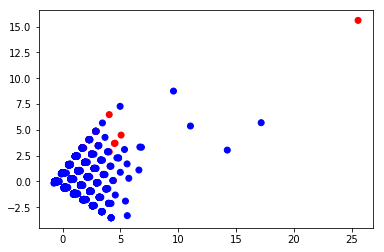

In [111]:
plt.scatter(x_coord, y_coord, c=color)
plt.show()